In [1075]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle

import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [1076]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_feat.csv', parse_dates=True, index_col=0)

#### Drop the NaNs and inf scale data

In [1077]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

#### Get a list of the features

In [1078]:
features = list(df.columns[1:].values)

#### Scale the data

In [1079]:
df_sc, standard_scale_fit = scale_features(df[features])
df_final = pd.concat([df.skiers, df_sc], axis=1)
df_final.head()

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,pres_day_mon_open_lifts_sqrt,ln_pres_day_mon_open_lifts,xmas_mon_open_lifts_sq,xmas_mon_open_lifts_cu,xmas_mon_open_lifts_sqrt,ln_xmas_mon_open_lifts,mlk_mon_open_lifts_sq,mlk_mon_open_lifts_cu,mlk_mon_open_lifts_sqrt,ln_mlk_mon_open_lifts
2011-11-13,845,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.458228,-0.27144,-0.175759,-0.203505,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-14,732,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.425127,-0.27144,-0.351432,-0.203505,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-15,997,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.425127,-0.27144,-0.351432,-0.409121,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-16,1110,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.414094,-0.27144,-0.351432,-0.409121,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923
2011-11-17,1136,-0.273228,-1.598171,-2.256316,-2.779523,-2.047784,-1.403060,-0.27144,-0.351432,-0.409121,...,-0.079236,-0.079247,-0.08282,-0.079784,-0.086521,-0.0867,-0.078294,-0.077121,-0.079196,-0.07923


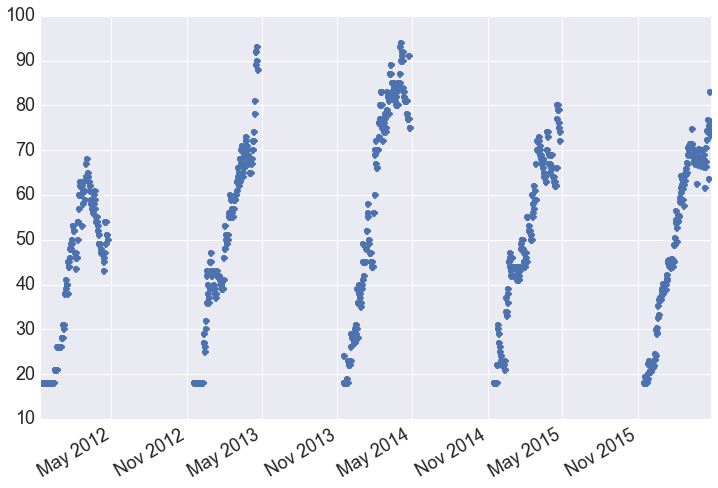

In [1080]:
df.basedepth.plot(linestyle='', marker='o')

### Create a training and holdout set

In [1081]:
df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
#df_tr = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2014,5,1)]
df_h = df.ix[datetime.datetime(2012,11,1):datetime.datetime(2013,5,1)]
df_fut = df.ix[datetime.datetime(2011,5,1):]

## Forward selection

In [1082]:
lin_regr = linear_model.LinearRegression()

In [1083]:
ref_column = 'skiers'
features = list(df_tr.columns.values)
features.remove('skiers')

In [1084]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features].values

In [1085]:
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos].skiers
y_tr_apr = df_tr.iloc[apr_pos].skiers

In [1086]:
leave_out = ['day_5', 'midweek', 'day_0', 'xmas', 'day_4', 'day_0', 'spring_break']
features_input = [f for f in features if f not in leave_out]

In [1088]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 35, features_input, y_tr_mar, y_tr_apr, mar_pos, apr_pos)

Next best Feature:  month_4 , RMSE:  1415.7 #: 7
Next best Feature:  tot_snow_cu , RMSE:  1374.3 #: 8
Next best Feature:  day_4_open_lifts_sq , RMSE:  1242.0 #: 9
Next best Feature:  month_4_sat , RMSE:  1225.7 #: 10
Next best Feature:  month_4_open_lifts , RMSE:  1220.4 #: 11
Next best Feature:  month_2_midweek , RMSE:  1206.4 #: 12
Next best Feature:  month_2_fri , RMSE:  1184.3 #: 13
Next best Feature:  thanksgiv_fri , RMSE:  1162.5 #: 14
Next best Feature:  before_xmas , RMSE:  1137.3 #: 15
Next best Feature:  month_12_open_lifts_cu , RMSE:  1094.8 #: 16
Next best Feature:  ln_week_snow_tot_sat , RMSE:  1090.8 #: 17
Next best Feature:  pres_day_sun_open_lifts_cu , RMSE:  1061.6 #: 18
Next best Feature:  thanksgiv_midweek , RMSE:  1030.2 #: 19
Next best Feature:  week_snow_tot , RMSE:  1028.7 #: 20
Next best Feature:  ln_week_snow_tot_fri , RMSE:  1025.0 #: 21
Next best Feature:  pres_day_sat_open_lifts , RMSE:  993.8 #: 22
Next best Feature:  month_4_midweek , RMSE:  991.8 #: 23
Ne

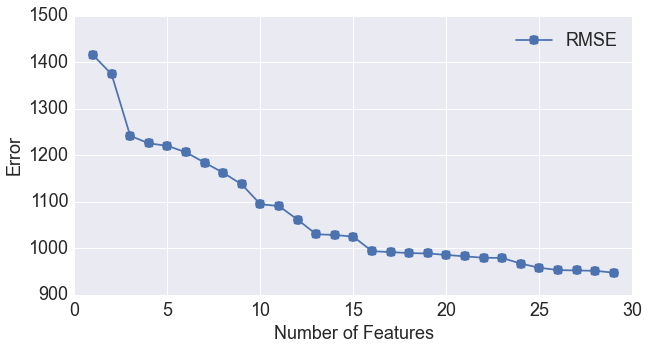

In [1089]:
plot_error_vs_features(RMSE, 'none', 'none')

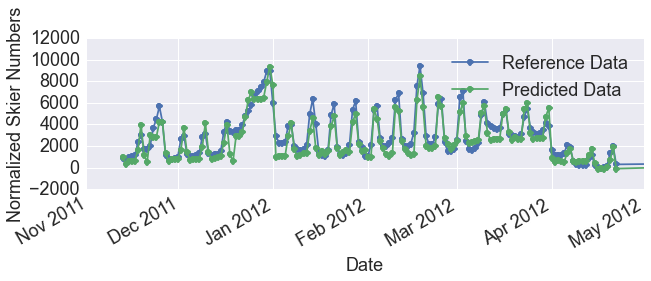

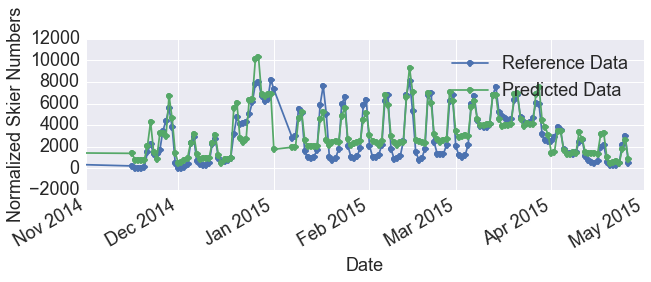

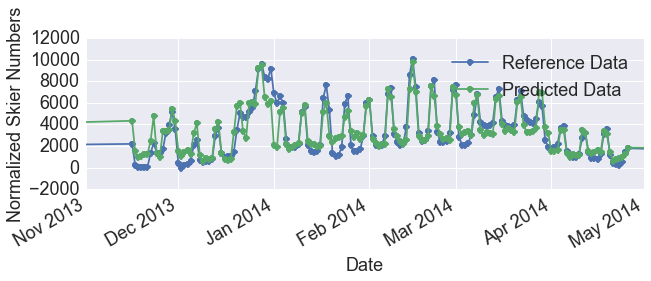

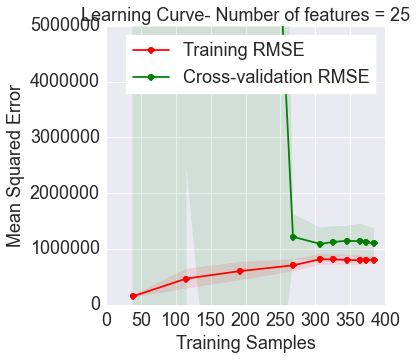

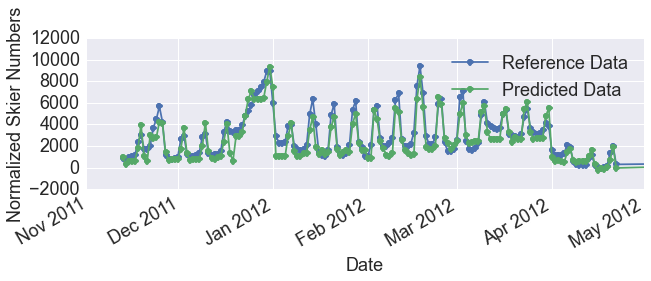

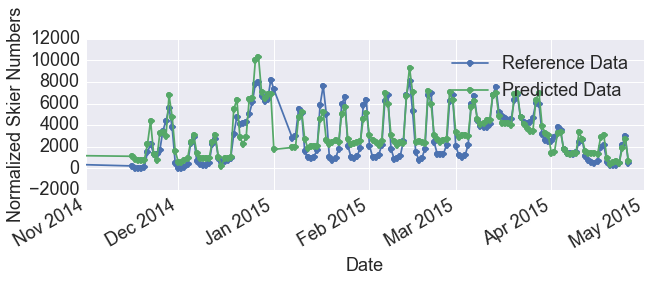

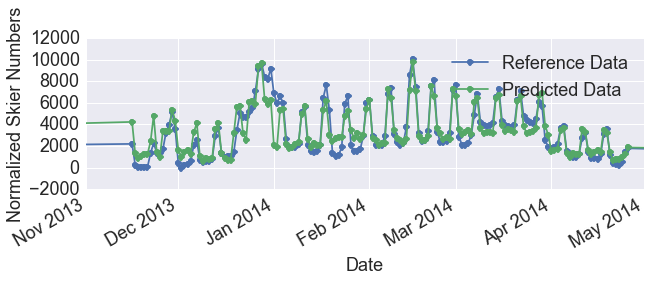

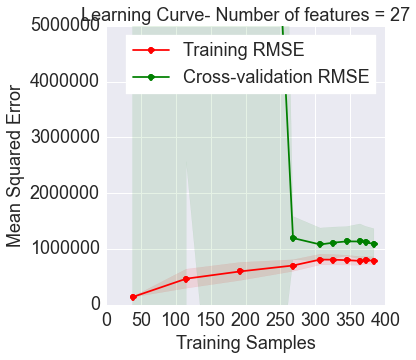

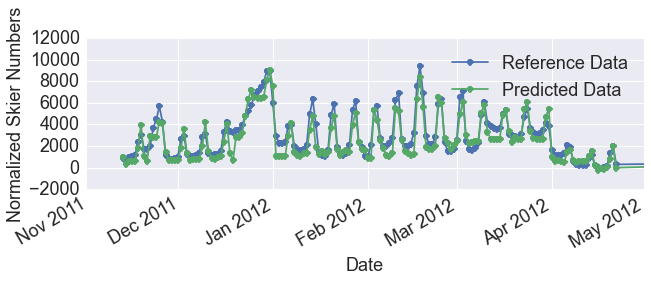

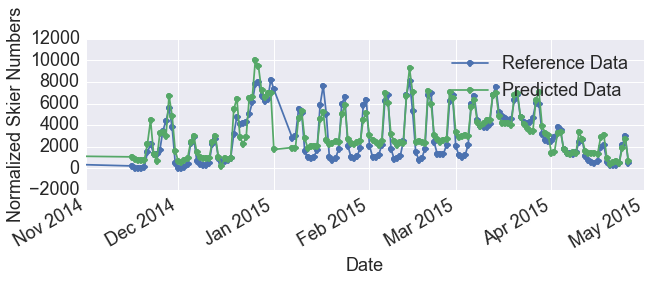

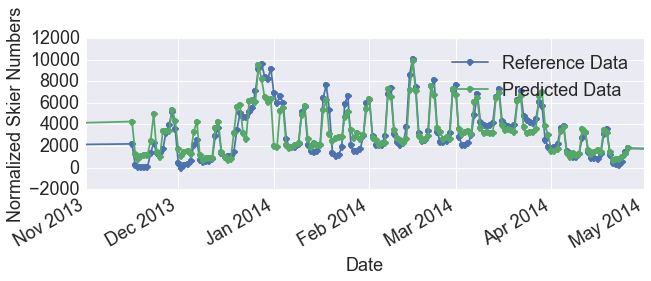

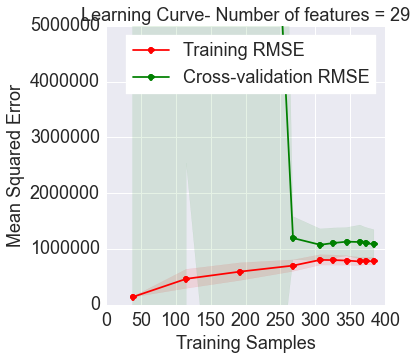

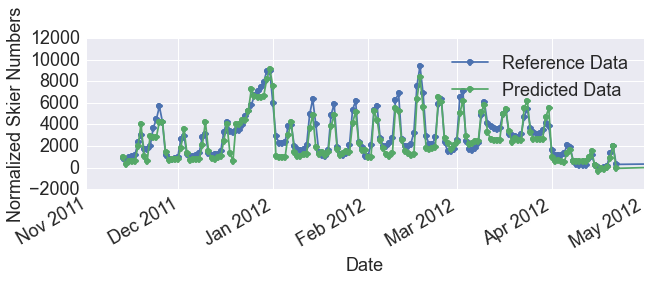

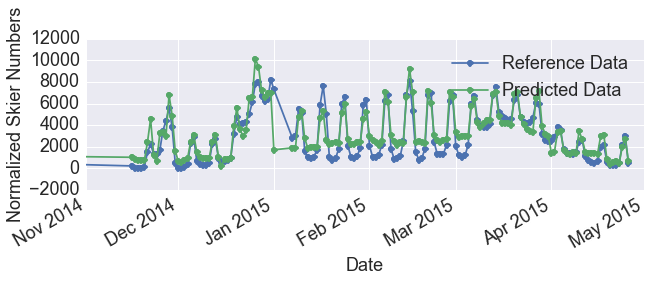

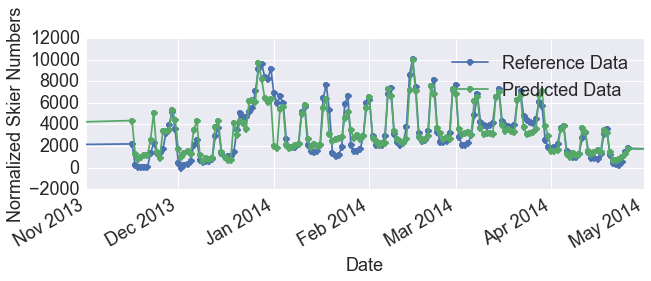

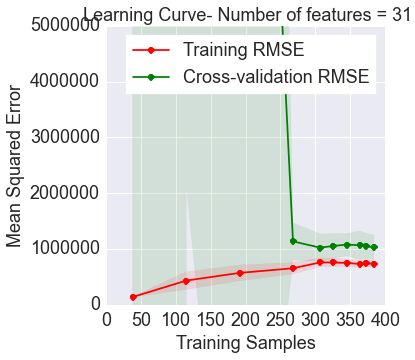

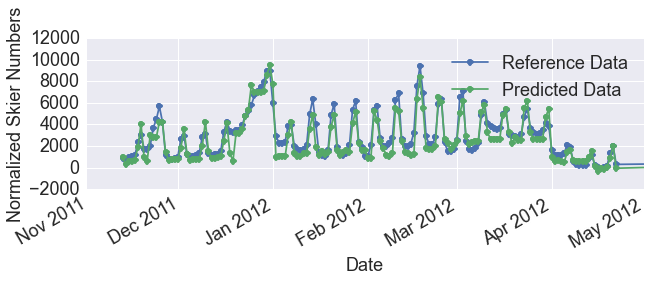

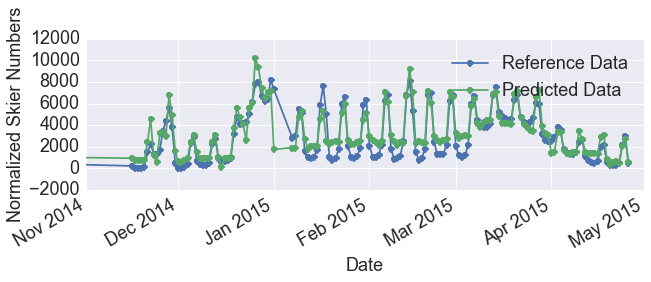

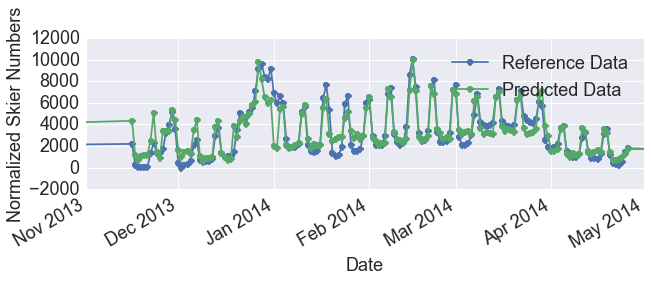

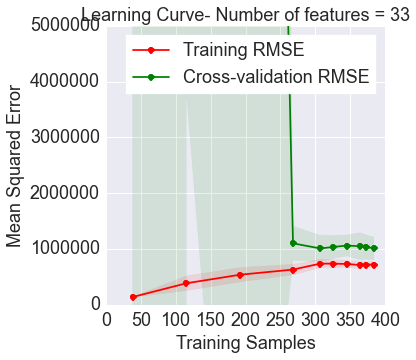

In [1097]:
i = 25
while i < 35:
    num_good_feat = i
    df_reg = pd.concat([df_tr.skiers, df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr.skiers.values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], 1200, (10,3))
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], 1200, (10,3))
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], 1200, (10,3))
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,5000000), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

In [1071]:
fs_features = ['day_5', 'midweek', 'day_0', 'xmas', 'spring_break', 'tot_snow', 'month_4', 'tot_snow_cu', 
               'day_4_open_lifts_sq', 'month_4_sat', 'month_4_open_lifts', 'month_2_midweek', 'month_2_fri', 
               'thanksgiv_fri', 'before_xmas', 'month_12_open_lifts_cu', 'ln_week_snow_tot_sat', 
               'pres_day_sun_open_lifts_cu', 'thanksgiv_midweek', 'week_snow_tot', 'ln_week_snow_tot_fri', 
               'pres_day_sat_open_lifts', 'month_4_midweek', 'month_4_mon', 'new_24_midweek_sqrt', 'new_24_sqrt', 
               'ln_week_snow_tot_spring_break', 'xmas_sat_open_lifts_cu', '2day_snow_tot_spring_break_sqrt', 
               'before_xmas_fri_open_lifts_sq', 'before_xmas_sat_sat', 'ln_before_xmas_weekday_open_lifts', 
               '4day_snow_tot_xmas_cu', 'month_11_fri', 'mlk_day_fri']

In [1116]:
num_feat = 30
best_features = fs_features[0:num_feat]

In [1117]:
RMSE_H_lin, RMSE_CV, df_H_lin, df_cv_lin = get_holdout_RMSE(lin_regr, best_features, df_tr, df_h)

CV RMSE: 967.0 ,  Holdout RMSE: 1109.6


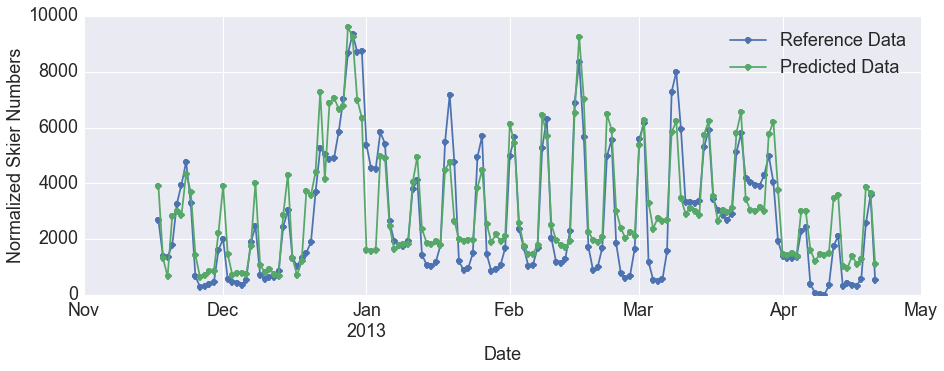

In [1118]:
plot_fitted_and_ref_vs_time(df_H_lin, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE, (15,5))

### Lasso

In [1101]:
features = list(df.columns.values)
features.remove('skiers')

In [1102]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features]
y_h = df_h.skiers.values

In [1103]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-5, 10000000, 1.5)

Best Lambda: 14346.0


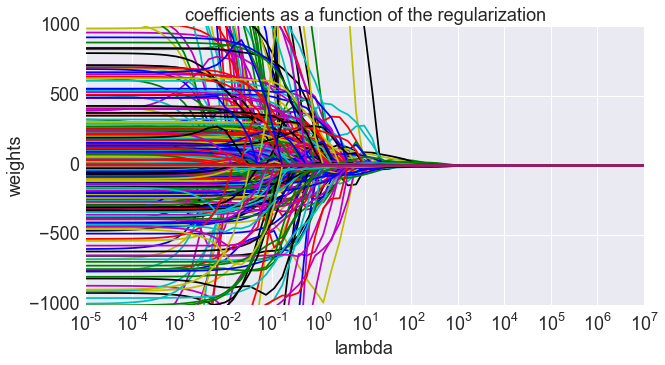

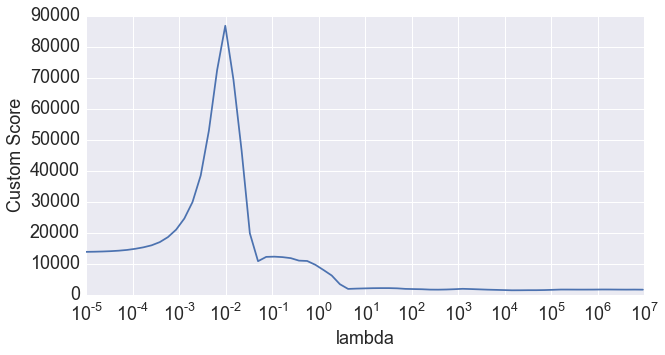

In [1104]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda, (-1000,1000))

#### Find cross-validation and holdout RMSE

In [1105]:
clf = linear_model.Lasso(alpha=best_lambda)

In [1106]:
RMSE_ls_H, RMSE_ls_CV, df_ls_hold, df_ls_cv = get_holdout_RMSE(clf, features, df_tr, df_h)

CV RMSE: 1533.6 ,  Holdout RMSE: 1170.1


#### Plot the holdout lasso prediction vs the reference data

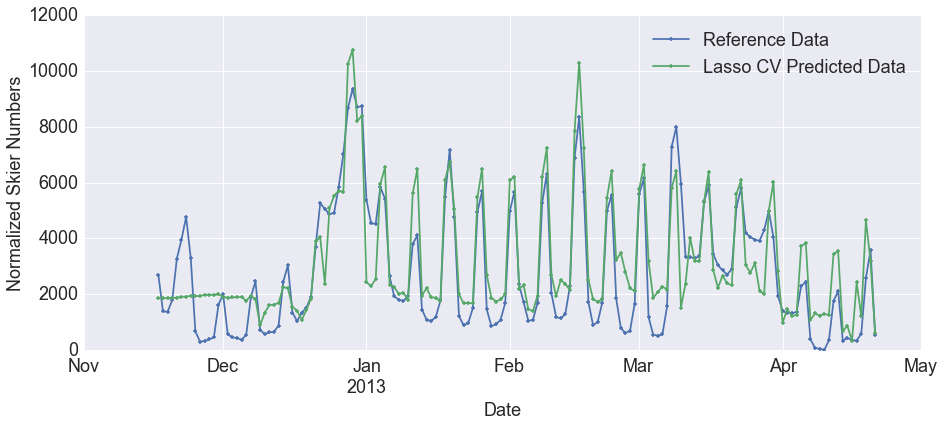

In [1114]:
plot_lasso_and_ref_vs_time(df_ls_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])

## Random Forest

In [1108]:
features = fs_features

In [1109]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features]
y_h = df_h.skiers.values

#### Fit the random forest regressor and find cross-validation stats

In [1110]:
rfr = RandomForestRegressor(n_estimators = 150, oob_score = True, n_jobs = -1)

In [1111]:
RMSE_rf_H, RMSE_rf_CV, df_rf_hold, df_rf_cv = get_holdout_RMSE(rfr, features, df_tr, df_h)

CV RMSE: 1367.9 ,  Holdout RMSE: 1219.2


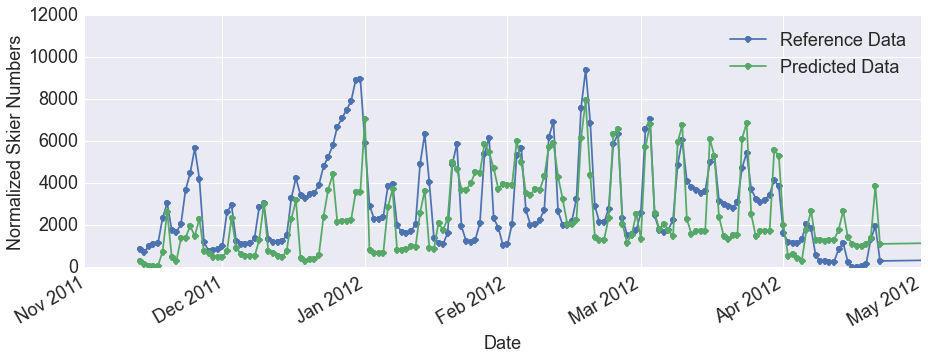

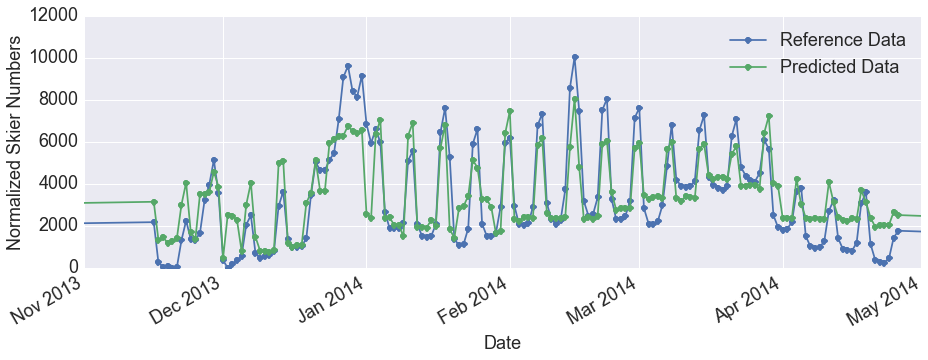

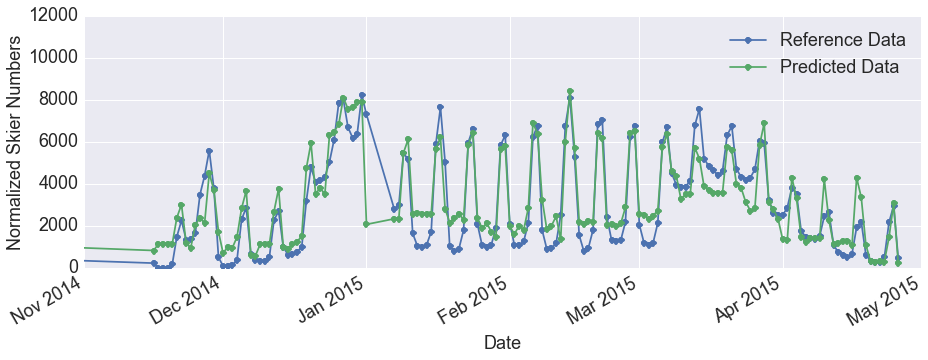

In [1112]:
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], RMSE_rf_CV, (15,5))

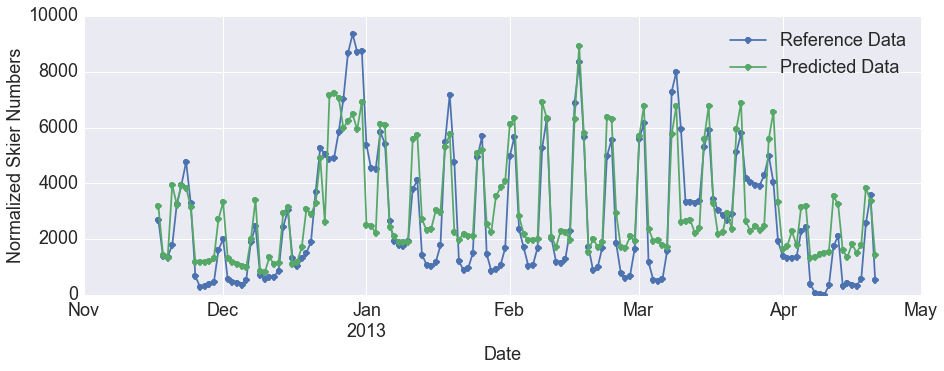

In [1113]:
plot_fitted_and_ref_vs_time(df_rf_hold, 'skiers', ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE_rf_H, (15,5))

### Export Linear Model with Best Features to Model

In [1120]:
X = df[best_features]
y = df.skiers
mdl = lin_regr.fit(X,y)

In [1121]:
#saving pickle file as .p is best
pickle_out = open('lin_regr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

# Export Data

In [1123]:
df_out = df.drop('skiers', axis=1)

In [1124]:
df_out.to_csv('../webpage_ski/df_all_features.csv')